## Accessing GOES Geostationary Lightning Mapper (GLM) with the Planetary Computer STAC API

The [Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html) is a single-channel, near-infrared optical transient detector that can detect the momentary changes in an optical scene, indicating the presence of lightning. GLM measures total lightning (in-cloud, cloud-to-cloud and cloud-to-ground) activity continuously over the Americas and adjacent ocean regions with near-uniform spatial resolution of approximately 10 km. GLM collects information such as the frequency, location and extent of lightning discharges to identify intensifying thunderstorms and tropical cyclones. Trends in total lightning available from the GLM provide critical information to forecasters, allowing them to focus on developing severe storms much earlier and before these storms produce damaging winds, hail or even tornadoes.

The GLM data product consists of a hierarchy of earth-located lightning radiant energy measures including events, groups, and flashes:

- Lightning "events" are detected by the instrument.
- Lightning "groups" are a collection of one or more lightning events that satisfy temporal and spatial coincidence thresholds.
- Similarly, lightning "flashes" are a collection of one or more lightning groups that satisfy temporal and spatial coincidence thresholds.
The product includes the relationship among lightning events, groups, and flashes, and the area coverage of lightning groups and flashes. The product also includes processing and data quality metadata, and satellite state and location information.

This Collection contains GLM L2 data in tabular ([GeoParquet](https://github.com/opengeospatial/geoparquet)) format and the original source NetCDF format. The NetCDF files are delivered to Azure as part of the [NOAA Open Data Dissemination (NODD) Program](https://www.noaa.gov/information-technology/open-data-dissemination).

### Data Access
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. The API key may be manually set via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more. 

In [1]:
import planetary_computer
import pystac_client
import rich.table

# Open the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

The GOES GLM product is queried by datetime and the "GOES-16" and "GOES-17" platforms. 

In [2]:
# Fetch the collection of interest and display available items
search = catalog.search(
    collections="goes-glm",
    datetime="2022-10-26T00:02:50Z",
    query={"platform": {"eq": "GOES-17"}},
)
items = list(search.get_items())
items

[<Item id=OR_GLM-L2-LCFA_G17_s20222990002400_e20222990003000>]

### Available Assets

Let's display the available assets and metadata for the GOES GLM product. 

In [3]:
# Assets
t = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                ┃ Value                                 ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ netcdf             │ Original NetCDF4 file                 │
│ geoparquet_events  │ Processed GeoParquet file for events  │
│ geoparquet_groups  │ Processed GeoParquet file for groups  │
│ geoparquet_flashes │ Processed GeoParquet file for flashes │
└────────────────────┴───────────────────────────────────────┘

In [4]:
# Metadata
t = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                                  ┃ Value                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                        │ GOES                        │
│ datetime                             │ 2022-10-26T00:02:50Z        │
│ end_datetime                         │ 2022-10-26T00:03:00.0Z      │
│ goes:event_count                     │ 1110                        │
│ goes:flash_count                     │ 34                          │
│ goes:flash_time_threshold            │ 3.3299999237060547          │
│ goes:group_count                     │ 523                         │
│ goes:group_time_threshold            │ 0.0                         │
│ goes:lightning_wavelength            │ 777.3699951171875           │
│ goes:nominal_satellite_height        │ 35786.0234375               │
│ goes:nominal_satellite_subpoint_lat  │ 0.0                         │
│ goes:nominal_satellite_subpoint_lon  │ -137.1999969482422          │
│ goes:orbital_slot                    │ West                        │
│ goes:percent_navigated_L1b_events    │ 1.0                         │
│ goes:percent_uncorrectable_L0_errors │ 0.0                         │
│ goes:system_environment              │ OR                          │
│ goes:yaw_flip_flag                   │ 2                           │
│ gsd                                  │ 8000                        │
│ instruments                          │ ['FM2']                     │
│ mission                              │ GOES                        │
│ platform                             │ GOES-17                     │
│ processing:facility                  │ WCDAS                       │
│ processing:level                     │ L2                          │
│ proj:centroid                        │ {'lat': 0.0, 'lon': -137.0} │
│ proj:epsg                            │ 4326                        │
│ start_datetime                       │ 2022-10-26T00:02:40.0Z      │
└──────────────────────────────────────┴─────────────────────────────┘

### Loading the GeoParquet dataset
Now let's load a STAC item into a tabular format. 

In [5]:
import geopandas
import pyarrow.fs
import fsspec

In [6]:
# Display the GOES GLM tabular data
fs = pyarrow.fs.PyFileSystem(pyarrow.fs.FSSpecHandler(fsspec.filesystem("http")))
asset = items[0].assets["geoparquet_groups"]

df = geopandas.read_parquet(asset.href, filesystem=fs)
df

,geometry,id,time,time_offset,frame_time,frame_time_offset,area,energy,quality_flag,parent_flash_id
0,POINT (-91.41206 15.12315),41316820,2022-10-26 00:02:41.279088+00:00,1.279088,2022-10-26 00:02:41.407264+00:00,1.407264,5.319701e+08,1.438346e-14,0,19663
1,POINT (-91.42130 15.11019),41316821,2022-10-26 00:02:41.358436+00:00,1.358436,2022-10-26 00:02:41.486993+00:00,1.486993,1.240653e+09,4.098026e-14,0,19663
2,POINT (-91.43069 15.12149),41316824,2022-10-26 00:02:41.438164+00:00,1.438164,2022-10-26 00:02:41.566339+00:00,1.566339,1.063330e+09,3.208133e-14,0,19663
3,POINT (-91.46420 15.12907),41316826,2022-10-26 00:02:41.507592+00:00,1.507592,2022-10-26 00:02:41.636149+00:00,1.636149,8.850908e+07,2.184922e-15,0,19663
4,POINT (-91.17548 15.04030),41316827,2022-10-26 00:02:41.958878+00:00,1.958878,2022-10-26 00:02:42.087435+00:00,2.087435,1.782390e+08,6.984346e-15,0,19664
...,...,...,...,...,...,...,...,...,...,...
518,POINT (-179.59244 23.99698),41317376,2022-10-26 00:02:59.243156+00:00,19.243156,2022-10-26 00:02:59.371332+00:00,19.371332,7.706394e+07,1.088388e-14,0,19714
519,POINT (-179.59253 23.99699),41317377,2022-10-26 00:02:59.248878+00:00,19.248878,2022-10-26 00:02:59.377436+00:00,19.377436,7.706394e+07,1.498339e-14,0,19714
520,POINT (-179.59258 23.99700),41317378,2022-10-26 00:02:59.251167+00:00,19.251167,2022-10-26 00:02:59.379343+00:00,19.379343,7.706394e+07,1.528335e-14,0,19714
521,POINT (-179.59239 23.99695),41317379,2022-10-26 00:02:59.382395+00:00,19.382395,2022-10-26 00:02:59.510571+00:00,19.510571,7.706394e+07,6.784370e-15,0,19714


### Displaying the data

Let's display the GOES GLM product across the western hemisphere. 

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

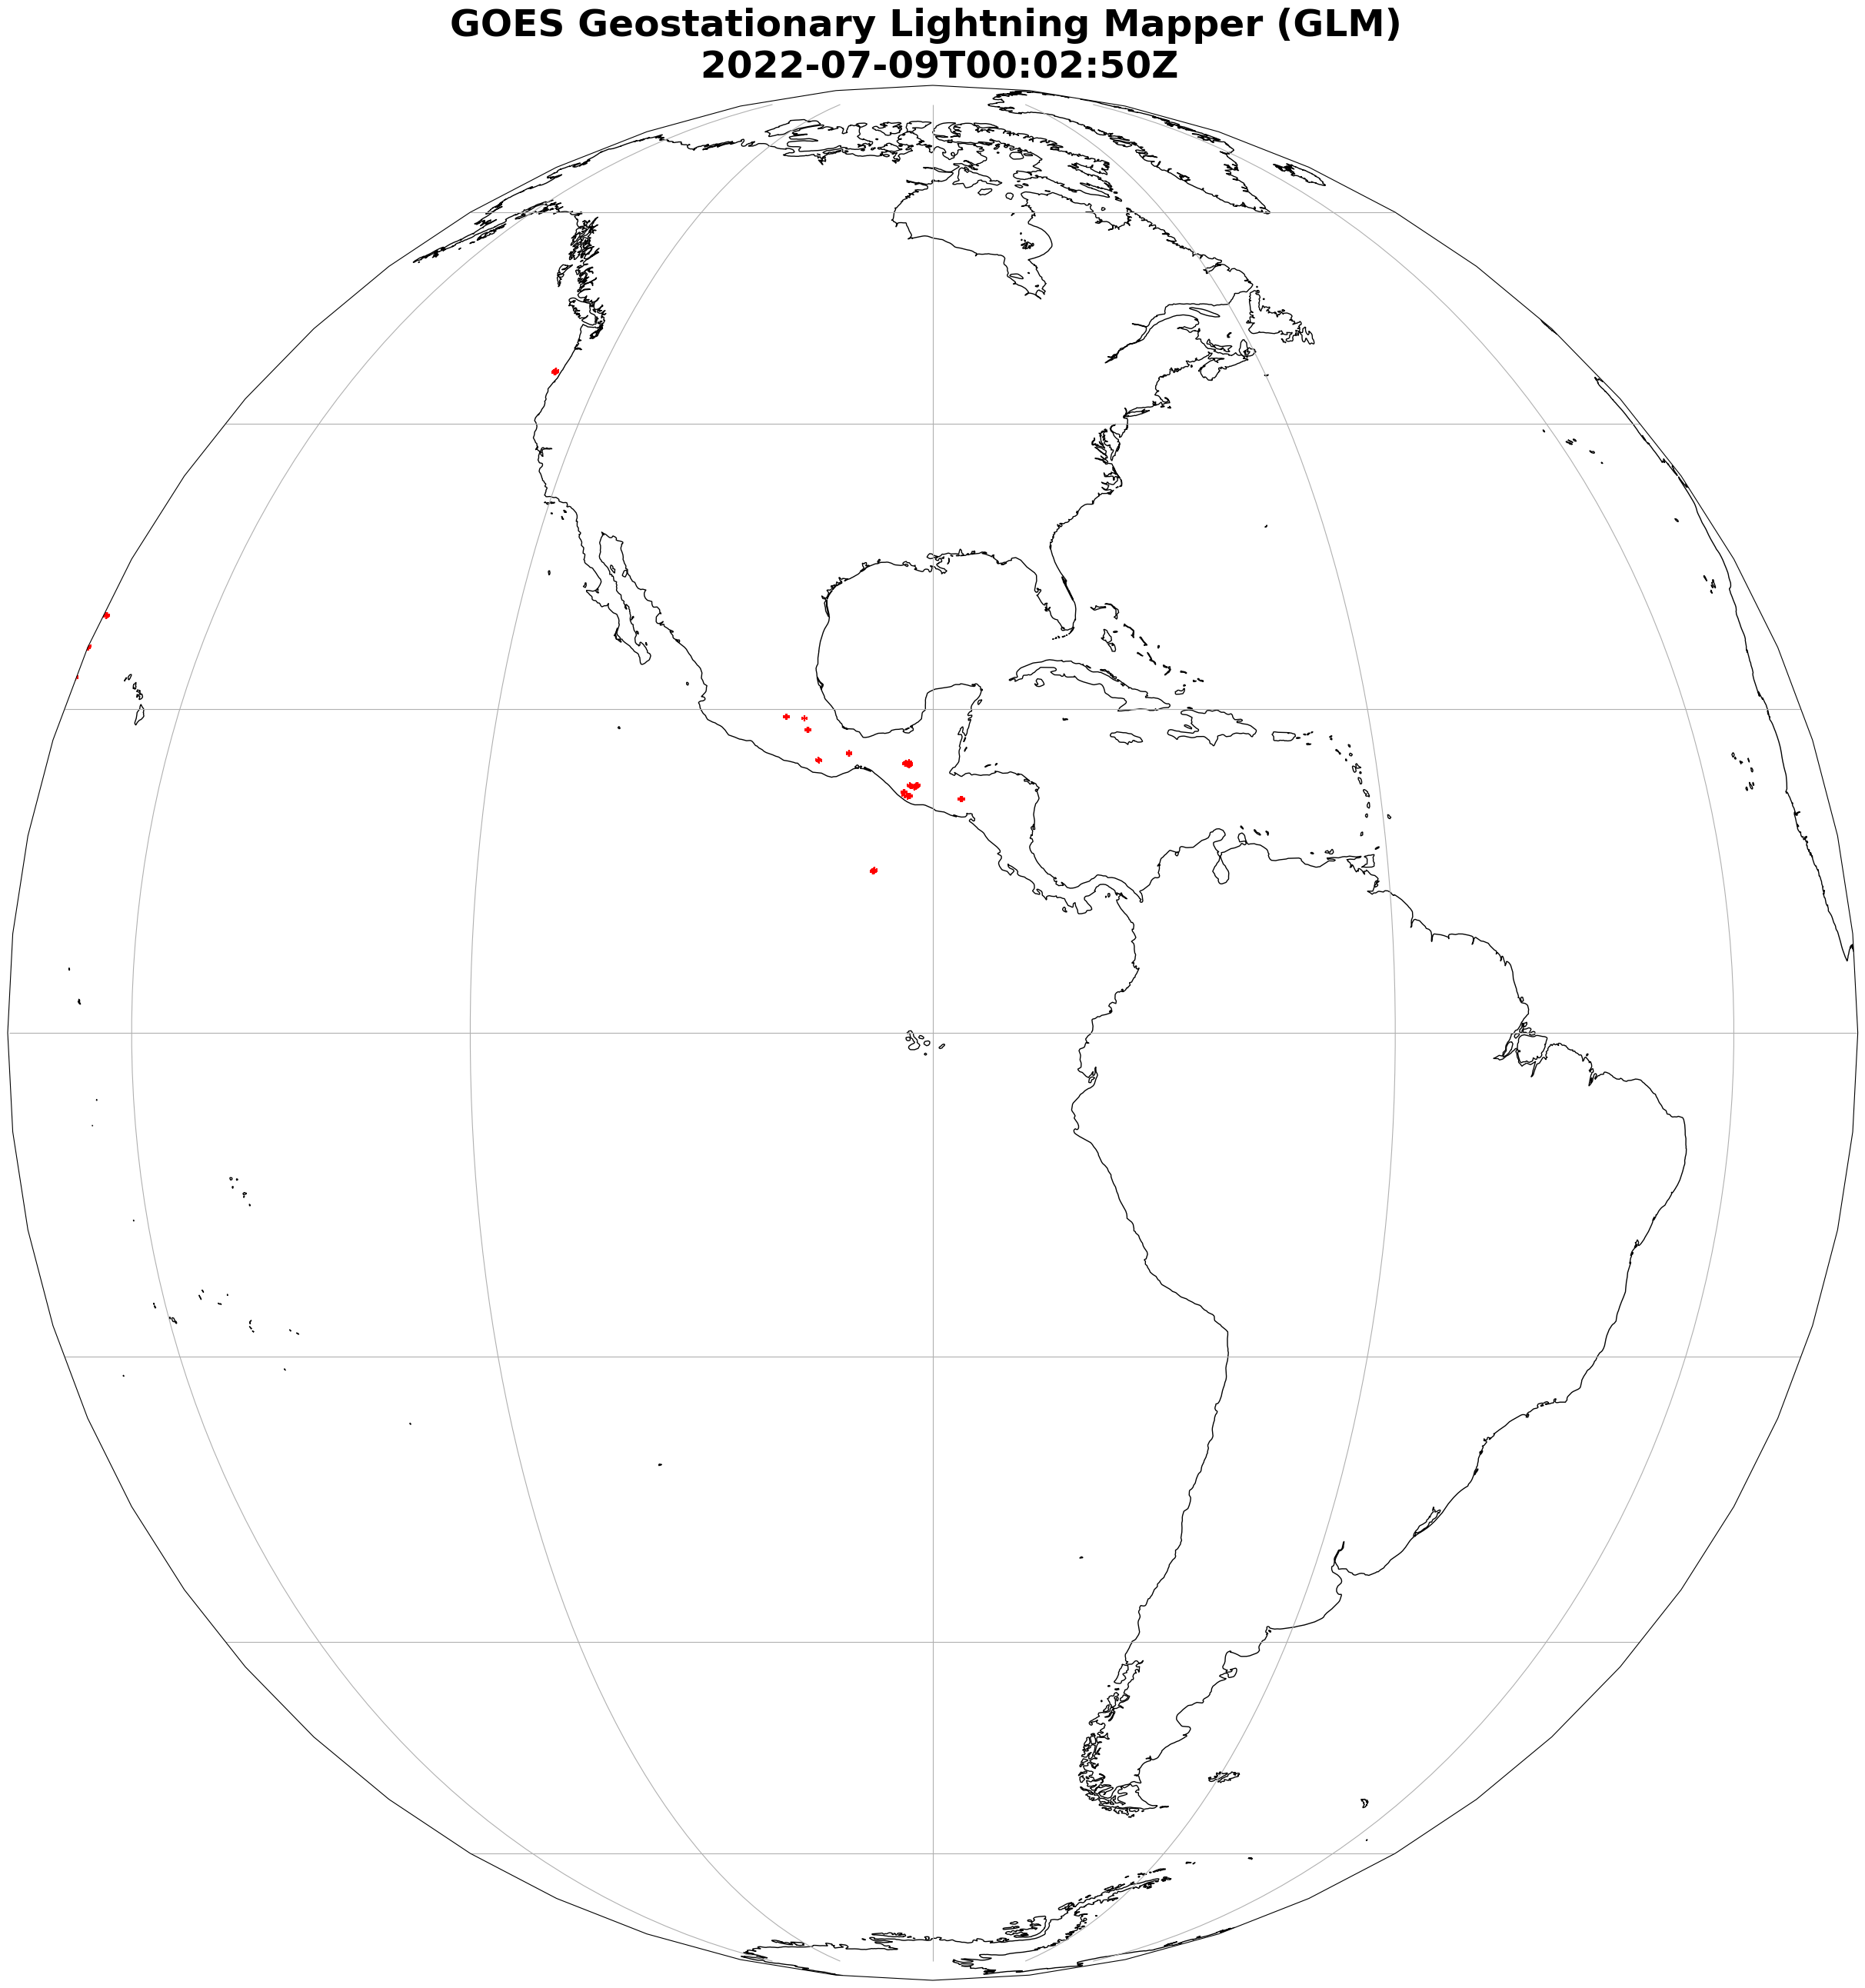

In [8]:
# Display the GOES GLM "group" product centriod location
fig, ax = plt.subplots(
    figsize=(32, 32),
    subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=-90.0)),
)

df.geometry.plot(ax=ax, facecolor="red", marker="+", transform=ccrs.PlateCarree())

ax.coastlines(resolution="50m")
ax.set_global()
ax.gridlines()
ax.set_title(
    "GOES Geostationary Lightning Mapper (GLM) \n 2022-07-09T00:02:50Z",
    fontweight="bold",
    fontsize="35",
);

### Reading many items

When working with this many items, just doing operations like reading the metadata of a parquet file for each asset can add up. This search, over a longer time window, returns several hundred items.

In [9]:
search = catalog.search(
    collections=["goes-glm"], datetime="2022-10-26T15:00:00/2022-10-26T16:00:00Z"
)
items = search.item_collection()
len(items)

362

You might want to parallelize tasks working with this many files using some parallel computing framework. In this example, we'll use [Dask](https://dask.org).

In [10]:
import dask_geopandas

In [16]:
%%time
ddf = dask_geopandas.read_parquet(
    [item.assets["geoparquet_events"].href for item in items], filesystem=fs
)

CPU times: user 3.09 s, sys: 308 ms, total: 3.4 s
Wall time: 17.3 s


In [17]:
%%time
energy = ddf["energy"].compute()

KeyError: 'OR_GLM-L2-LCFA_G16_s20222991500000_e20222991500200_c20222991500214_events.parquet?st'

In [14]:
import seaborn as sns

ax = sns.displot(energy, log_scale=True)
ax.set(xlabel="Energy (joules)");

NameError: name 'energy' is not defined